
#### <img src="Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />
<hr style="height:2px;border:none"/>
<h1 align='center'> CIV-348 Obras Marítimas - 2019-2 </h1>

<H3 align='center'> Tarea 2   </H3>
<H3 align='center'> Diego UmañanaJ-Jorge Nuñez  </H3>
<H3 align='center'> Bastian Castro-Rodrigo Villalobo  </H3>
<hr style="height:2px;border:none"/>


## Tarea 2: Refracción.

En el archivo adjunto se encuentrán los datos de la batimetria de sector de  San Antonio, el archivo consta de 3 columnas, la primera corresponde a la coordenada `Este (medida de Oeste a Este)`, la segunda corresponde a la coordenada `Sur (medida de Sur a Norte)` ambas en `metro`. La tercera corresponde a la `Profundidad (z positivo hacia abajo)` en `metro`.
Utilizando estos datos se deberá hacer un análisis de refracción y número de ondas para dicho sector.

Para ello deberán generar un programa de seguimiento de rayos sencillos, basado en la ecuación de `Snell`, y utilizando la ecuación de dispersión. Esto significa que debe indicar la trayectoria que siguiria una ola al propagarse sobre dicha batimetría.


Deben considerar oleajes provenientes desde aguas profundas, con ángulos desde el `Oeste`, `Sur-Oeste` y `Nor-Oeste`. Como mínimo, deben realizar la propagación desde los puntos con coordenadas (pero pueden incluir más si así lo desean).
Dederán hacer el análisis con dos períodos, 14 y 25 segundos.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.mlab
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mis_funciones import newton
from funciones_maritima import crear_rayos
from scipy.optimize import fsolve
import pylab

#### A continuación se carga la data para ser analizada posteriormente.

In [2]:
df = pd.read_csv('MyMatrix.csv')

In [3]:
df.describe()

,Coord.Este[m],Coord.Sur[m],Profundidad[m]
count,49395.000000,49395.000000,49395.000000
mean,2402.212432,4102.611086,44.424466
std,1394.449047,2377.555758,65.808872
min,0.000000,0.000000,0.000000
25%,1201.110000,2035.880000,0.020000
50%,2402.210000,4102.610000,21.230000
75%,3603.320000,6169.340000,45.500000
max,4804.420000,8205.220000,338.530000


In [4]:
df.head(10)


,Coord.Este[m],Coord.Sur[m],Profundidad[m]
0,0.0,0.00,156.15
1,0.0,30.85,186.31
2,0.0,61.69,234.64
3,0.0,92.54,282.31
4,0.0,123.39,296.46
5,0.0,154.23,304.61
6,0.0,185.08,305.49
7,0.0,215.93,299.63
8,0.0,246.77,295.32
9,0.0,277.62,292.47


In [5]:
df.isnull().sum()

Coord.Este[m]     0
Coord.Sur[m]      0
Profundidad[m]    0
dtype: int64

**Comentario :** Se puede observar que la data no contiene datos faltantes.

#### Descripción del DataFrame MyMatrix.
Esta data contiene los datos de profundidad de la bahia de San Antonio, registradas geograficamente o sea cada medición se registra en conjunto a su coordenada Este [m]  y coordenada Sur [m].

|Columns                    | Descripción                           |
|:------------------------- |:------------------------------------- |
|Coord.Este[m]              | Corresponde a la coordenadada Este del punto de medición [m] |
|Coord.Sur[m]               | Corresponde a la coordenadada Sur del punto de medición [m]   |
|Profundidad[m]             | Profundidad del punto de medición positiva [m]     |

#### Acontinuación se designan las variables `Este` ,  `Sur`  y ` Prof`  extraidas de la data para su posterior uso.

In [6]:
Este = list(df['Coord.Este[m]'])
Sur = list(df['Coord.Sur[m]'])
Prof = list(df['Profundidad[m]'])

#### Coordenadas iniciales y finales Sur y Este.

In [7]:
sur_end = df['Coord.Sur[m]'][49394]
sur_in = df['Coord.Sur[m]'][0]
este_end = df['Coord.Este[m]'][49394]
este_in = df['Coord.Este[m]'][0]

#### A continuación se raliza la grilla de la zona de estudio en la que se trata de mantener los pasos de los registros originales en coordenadas Este y Sur.

In [8]:
# construcción de la grilla 2D
si = np.linspace(sur_in, sur_end,266)
ei = np.linspace(este_in, este_end,185)
E, S = np.meshgrid(ei, si)

#### La función griddata interpola los valores asociados a la grilla, dado los valores originales de los registros.

In [9]:
Z = griddata((Este, Sur), Prof,( E, S), method='linear')
ge, gs = np.gradient(Z)


#### Se gráfica la batimetria de la zona de estudio.

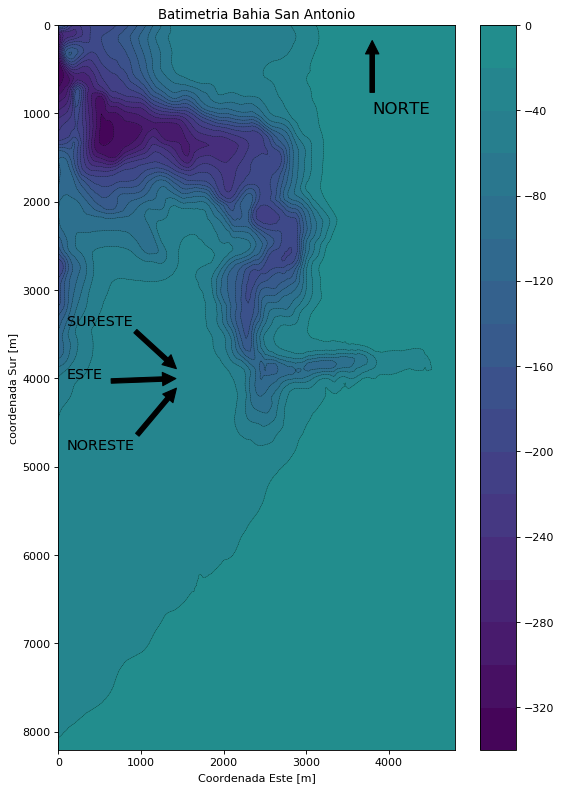

In [10]:
fig = plt.figure(figsize=(8,12), dpi=80)

ax = plt.gca()
ax.invert_yaxis()
#pylab.contour(ei, si, -Z.transpose(), 30, colors='k', linestyles='--', linewidth=0.1)
plt.contour(ei, si, -Z, 20, linewidths=0.3, colors='k')
plt.contourf(ei, si, -Z, 20,
                vmax=abs(Z).max(), vmin=-abs(Z).max(),zorder =1)
plt.annotate('NORTE',xy=(3800,100),fontsize=15,xytext=(3800,1000),
             arrowprops=dict(facecolor='black',shrink=0.1))
plt.annotate('ESTE',xy=(1500,4000),fontsize=13,xytext=(100,4000),
             arrowprops=dict(facecolor='black',shrink=0.08))
plt.annotate('NORESTE',xy=(1440,4100),fontsize=13,xytext=(100,4800),
             arrowprops=dict(facecolor='black',shrink=0.02))
plt.annotate('SURESTE',xy=(1440,3900),fontsize=13,xytext=(100,3400),
             arrowprops=dict(facecolor='black',shrink=0.02))
plt.colorbar()  # draw colorbar

plt.title('Batimetria Bahia San Antonio' )#% npts)
plt.xlabel('Coordenada Este [m]')
plt.ylabel('coordenada Sur [m]')
plt.show()


#### Se define función metodo Snell, para su posterior uso.

In [11]:
def snell_f(g,T,k0,c0,theta0,h,xi,yi,ds,n,output):
    rayos1 = np.zeros((n,5))
    rayos1[0,:]=[xi,yi,theta0,c0,h]
    contador = 0
    while h >= 0.01 :
        if yi<=10: # se definen criterios de parada para no salir de los limites de la costa en estudio.
            break
        if yi>=8000:
            break
        contador+=1
        if contador == n:
            break
        def cf(k,g,T,h):
            return g*T**2/(2*np.pi)*np.tanh(k*h)-2*np.pi/k
        k = fsolve(cf,k0,args=(g,T,h))
        if k*h <= np.pi/10:
            #print('aguas somera')
            c= (g*h)**0.5
        elif k*h >= np.pi :
            #print('aguas profundas')
            c = g*T/(2*np.pi)
        else :
            #print('intermedias')
            c= (g*np.tanh(k*h)/k)**0.5
        gei =  griddata((np.concatenate(E), np.concatenate(S)), np.concatenate((ge)),(xi,yi), method='linear')
        gsi =  griddata((np.concatenate(E), np.concatenate(S)), np.concatenate((gs)),(xi,yi ), method='linear')
        #calcular angulo del vector normal con la batimetria.
        alpha = np.arctan(gsi/gei) 
        if c/c0 > 1:
            theta = theta0
        else :
            theta0 = alpha-theta0
            theta = np.arcsin(np.sin(theta0)*c/c0) # Ley de Snell

        dx = ds*np.cos(theta) # calculo deltas, respecto al nuevo theta
        dy = ds*np.sin(theta)
        xi = xi + dx # Nuevas coordenadas
        yi = yi + dy
        h =  griddata((Este, Sur), Prof,( xi, yi), method='linear') # profundidad asociada a las nuevas coordenadas 
       
        tt = theta0
        theta0 = theta # actualizar theta 
        k0 = k # actualizar k
        c1=c0
        c0=c # actualizar c
        rayos1[contador,:] = [xi,yi,theta0,c,h] # guardad información del rayo
        
    print(contador)
    output.put(rayos1)
    #return rayos1
    

#### Ejecutar cuatro Snell en paralelo, con distos puntos de partida.

In [12]:
import multiprocessing as mp
from multiprocessing import Process
g = 9.80665
T = 14 # Periodo ola proveniente en segundos.
L0 = g*T**2/(2*np.pi) # Longitud ola inicial Aguas Profundas
k0 = 2*np.pi/L0 # numero de onda ola inicial
c0 = g*T/(2*np.pi)
theta0 = 0*np.pi/4 # condicion inicial
ds= 20 #Deltas 
n = 300
output = mp.Queue()
#-----------------------------------------------------------------------
if __name__ == '__main__':
    procs = []
    coordenadas = [[0, 1*10**3],[0, 2*10**3],[0, 3*10**3],[0, 4*10**3]]
    for coord in coordenadas:
        xi=coord[0] # Coordenada Este
        yi=coord[1] # coordenada Sur
        h =  griddata((Este, Sur), Prof,( xi, yi), method='linear') # Profundidad asociada a dicha coordenada
        proc = Process(target=snell_f, args=(g,T,k0,c0,theta0,h,xi,yi,ds,n,output))
        procs.append(proc)
        proc.start()
    for proc in procs:
        proc.join()
    resul_snell = [output.get() for proc in procs]
    

204
213
216
225


#### Obtener datos metodo Snell.
Se extraen los datos del arreglo resul_snell el cual almacena las distintas matrices rayos, que almacenan la información de cada rayo. 

In [13]:
X1 = resul_snell[0][:,0];X2 = resul_snell[1][:,0];X3= resul_snell[2][:,0];X4 = resul_snell[3][:,0]

Y1 = resul_snell[0][:,1];Y2 = resul_snell[1][:,1];Y3 = resul_snell[2][:,1];Y4 = resul_snell[3][:,1]

THETA1 = resul_snell[0][:,2];THETA2 = resul_snell[1][:,2];THETA3 = resul_snell[2][:,2];THETA4 = resul_snell[3][:,2]

C1= resul_snell[0][:,3];C2= resul_snell[1][:,3];C3= resul_snell[2][:,3];C4= resul_snell[3][:,3]

U1 = C1*np.cos(THETA1);U2 = C2*np.cos(THETA2);U3 = C3*np.cos(THETA3);U4 = C4*np.cos(THETA4)

V1 = C1*np.sin(THETA1);V2 = C2*np.sin(THETA2);V3 = C3*np.sin(THETA3);V4 = C4*np.sin(THETA4)

#### Graficos de resultados.
Se procede a graficar los resultados de propagación de los rayos, ante las bariaciones batimetricas de la bahía.

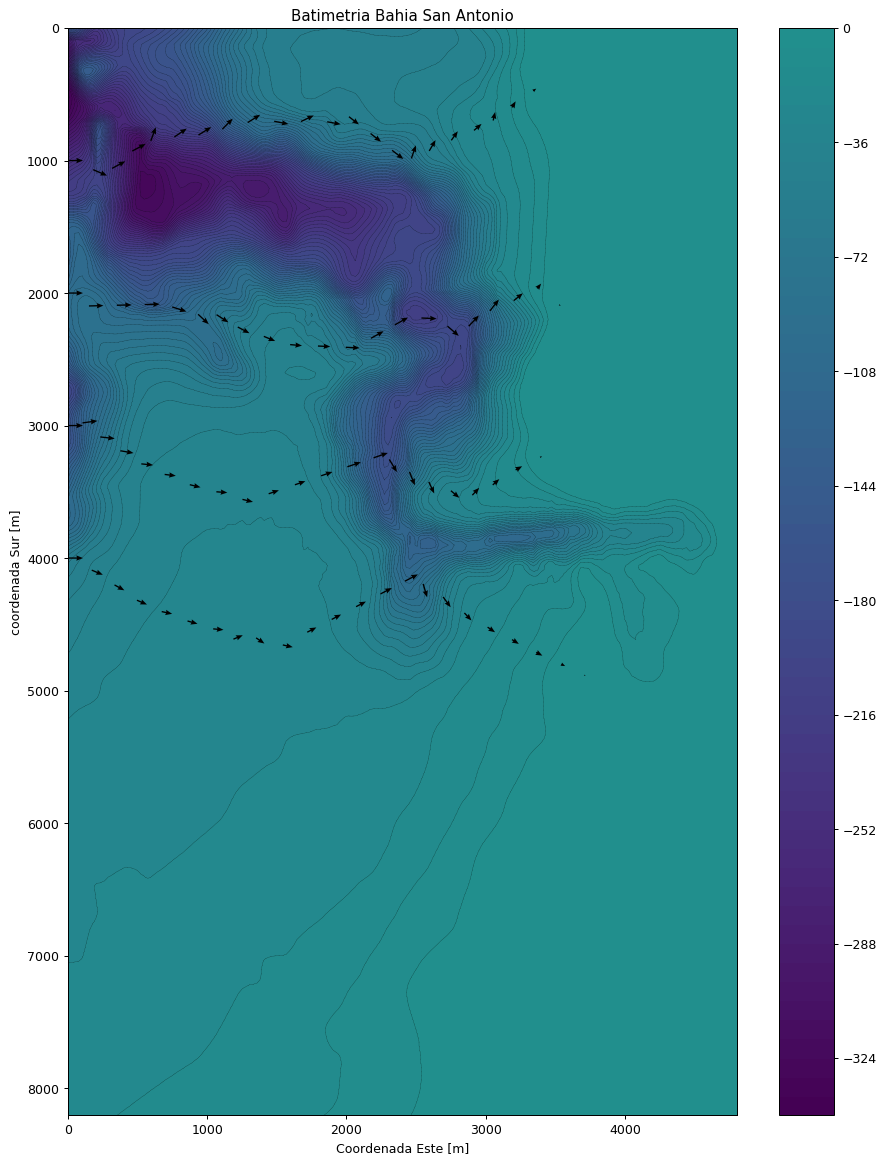

In [14]:
fig = plt.figure(figsize=(12,16), dpi=90)

ax = plt.gca()
ax.invert_yaxis()
#pylab.contour(ei, si, -Z.transpose(), 30, colors='k', linestyles='--', linewidth=0.1)
plt.contour(ei, si, -Z, 60, linewidths=0.2, colors='k')
plt.contourf(ei, si, -Z,60,
                vmax=abs(Z).max(), vmin=-abs(Z).max(),zorder =1)
plt.colorbar()  # draw colorbar

p=10 
    
pylab.quiver(X1[0::p], Y1[0::p], U1[0::p], V1[0::p], angles='xy', scale_units='xy', scale=0.2,
            width=0.002, headwidth=4, headlength=5)

pylab.quiver(X2[0::p], Y2[0::p], U2[0::p], V2[0::p], angles='xy', scale_units='xy', scale=0.2,
            width=0.002, headwidth=4, headlength=5)

pylab.quiver(X3[0::p], Y3[0::p], U3[0::p], V3[0::p], angles='xy', scale_units='xy', scale=0.2,
            width=0.002, headwidth=4, headlength=5)

ax.quiver(X4[0::p], Y4[0::p], U4[0::p], V4[0::p], angles='xy', scale_units='xy', scale=0.2,
          width=0.002, headwidth=4, headlength=5)

plt.title('Batimetria Bahia San Antonio' )#% npts)
plt.xlabel('Coordenada Este [m]')
plt.ylabel('coordenada Sur [m]')
plt.show()